In [0]:
import numpy as np
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint  
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
drive.mount('/content/drive', force_remount=True)
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive/  sample_data/


In [3]:
%cd "drive/My Drive/ChiragBTP"
%ls

/content/drive/My Drive/ChiragBTP
 acf_1dcnn_v2.ipynb                'GUI for Audio Scene Recognition (1).ipynb'
 acf_awgn_features.py               models/
 acf_features.py                    plot_acf_features.py
 ACF_plots.ipynb                    plots/
 cnn_1d.py                          raw_data/
 cnn_1d_v2.py                       sandbox.ipynb
 cnn.py                             sets_labels/
 code/                              spectrogram_generator.py
'Confusion plots.ipynb'             split_audio_file.py
 create_ACF_train-test_sets.ipynb  'Splitting audio samples.ipynb'
 create_MFCC_dataset.py             svm.ipynb
 extract_features.py                svm.py
 feature_extraction.ipynb           Untitled.py
 features/


In [0]:
train_set_file = os.path.join('sets_labels', 'ACF', '1hr', 'clean', 'train_set_v3.csv')
test_set_file = os.path.join('sets_labels', 'ACF', '1hr', 'clean', 'test_set_v3.csv')
train_label_file = os.path.join('sets_labels', 'ACF', '1hr', 'clean', 'train_labels_v3.csv')
test_label_file = os.path.join('sets_labels', 'ACF', '1hr', 'clean', 'test_labels_v3.csv')
test_deep_label_file = os.path.join('sets_labels', 'ACF', '1hr', 'clean', 'test_deep_labels_v3.csv')

plot_file = os.path.join('plots', 'ACF', '1D-CNN', '1d_cnn_v5.png')
weight_file = os.path.join('models', 'ACF', '1D-CNN', '1d_cnn_v5.hdf5')
info_file = os.path.join('models', 'ACF', '1D-CNN', '1d_cnn_v5.txt')
scaler_file = os.path.join('models', 'ACF', '1D-CNN', 'scaler_1d_cnn_v5.sav')

In [0]:
X_train = np.loadtxt(train_set_file)
X_test = np.loadtxt(test_set_file)
Y_train = np.loadtxt(train_label_file)
Y_test = np.loadtxt(test_label_file)
Y_deep_test = np.loadtxt(test_deep_label_file)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(Y_train.shape)
print(Y_test.shape)

joblib.dump(scaler, scaler_file)

(2625438, 3)
(291716, 3)
(2625438,)
(291716,)


['models/ACF/1D-CNN/scaler_1d_cnn_v5.sav']

In [7]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(Y_train.shape)
print(Y_test.shape)

(2625438, 3, 1)
(291716, 3, 1)
(2625438, 2)
(291716, 2)


In [0]:
n_timesteps, n_features = X_train_scaled.shape[1], X_train_scaled.shape[2]
epochs, batch_size = 100, 32
lr, momentum = 0.05, 0.7
#optimizer = SGD(lr=lr, momentum=momentum)
optimizer = Adam()

In [0]:
def make_model(n_timesteps=None, n_features=None):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [10]:
epochs_to_wait_for_improve = 5
model = make_model(n_timesteps=n_timesteps, n_features=n_features)
earlystopper = EarlyStopping(monitor='val_acc', patience=epochs_to_wait_for_improve, restore_best_weights=True)







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)          

In [11]:
hist = model.fit(X_train_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[earlystopper], validation_split=0.1)
model.save(weight_file)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2362894 samples, validate on 262544 samples
Epoch 1/100





2362894/2362894 [==============================] - 344s 146us/step - loss: 0.4571 - acc: 0.7867 - val_loss: 0.4425 - val_acc: 0.7951
Epoch 2/100
2362894/2362894 [==============================] - 339s 143us/step - loss: 0.4399 - acc: 0.7965 - val_loss: 0.4390 - val_acc: 0.7968
Epoch 3/100
2362894/2362894 [==============================] - 337s 143us/step - loss: 0.4362 - acc: 0.7981 - val_loss: 0.4360 - val_acc: 0.7986
Epoch 4/100
2362894/2362894 [==============================] - 330s 140us/step - loss: 0.4339 - acc: 0.7996 - val_loss: 0.4352 - val_acc: 0.7991
Epoch 5/100
2362894/2362894 [==============================] - 327s 138us/step - loss: 0.4329 - acc: 0.8003 - val_loss: 0.4300 - val_acc: 0.8017
Epoch 6/100
2362894/2362894 [==============================] - 326s 138us/step - loss: 0.4321 - acc: 0.8008 - val_loss: 

In [0]:
# from keras.models import load_model
# model = load_model(weight_file)
_, accuracy = model.evaluate(X_test_scaled, Y_test, batch_size=batch_size, verbose=1)
Y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(Y_pred, axis=1)
y_test_labels = np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
conf_mat2 = confusion_matrix(Y_deep_test,y_pred_labels)
clf_report = classification_report(y_test_labels, y_pred_labels)

In [11]:
print("acc=%0.3f" % accuracy)
print(conf_mat)
print(clf_report)
print(conf_mat2)

acc=0.805
[[109864  37484]
 [ 19524 124844]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.79    147348
           1       0.77      0.86      0.81    144368

    accuracy                           0.80    291716
   macro avg       0.81      0.81      0.80    291716
weighted avg       0.81      0.80      0.80    291716

[[60136 15346     0     0]
 [49728 22138     0     0]
 [ 3321 68758     0     0]
 [16203 56086     0     0]]


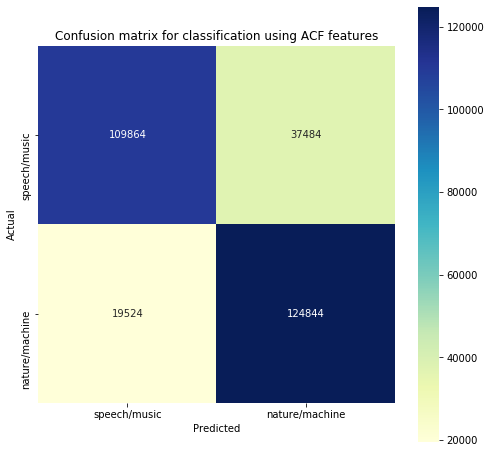

In [12]:
fig, ax = plt.subplots(figsize=(8,8))         
ax = sns.heatmap(conf_mat, annot=True, fmt='d', square=True, cmap="YlGnBu", 
                 xticklabels=['speech/music', 'nature/machine'], 
                 yticklabels=['speech/music', 'nature/machine'])
               
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix for classification using ACF features')
#plt.show()
plt.savefig(plot_file)

In [0]:
file_obj = open(info_file, 'w')
file_obj.write("MODEL SUMMARY\n")
#summary = model.summary()
model.summary(print_fn=lambda x: file_obj.write(x + '\n'))
file_obj.write("\n")
file_obj.write("Optimizer : Adam - batch_size = {}\n\n".format(batch_size))
#file_obj.write("Optimizer : SGD - lr = {}, momentum = {}\n\n".format(lr, momentum))

file_obj.write("\n\nTest accuracy = %0.3f\n\n" % accuracy)
file_obj.write("CLASSIFICATION REPORT\n")
file_obj.write(clf_report)

file_obj.write("\n\nFILE PATHS\n")
file_obj.write("Training set : {}\n".format(train_set_file))
file_obj.write("Testing set : {}\n".format(test_set_file))
file_obj.write("Weight file : {}\n".format(weight_file))
file_obj.write("Scaler file : {}\n".format(scaler_file))
file_obj.write("CM plot file : {}\n".format(plot_file))
file_obj.close()